In [1]:
# Import packages
import pandas as pd
import sqlite3
import random
import time
# SQL Query
conn = None
try:
    conn = sqlite3.connect("RAMSS Model.db") # TODO create prompt for this
except:
    print("error")

In [2]:
#brace frame columns
#ignored for gravity analysis
bf_cols = ["A-2","A-3","A-4","A-5","A-6","A-7",
                "H-1","H-2","H-2.7","H-5","H-6","H-7",
                "K-2","K-3",
                "F.2-1","E.4-1","D.5-1","C.5-1",
                "F.2-3","E.4-3","D.5-3","C.5-3",
                "F-8","E-8","D-8","C-8",
                "K-5.5","J-5.5",
                "H.8-1","H-1"]
bf_cols_to_sql = format(str(bf_cols)[1:-1])

In [3]:
#iterate over floor levels
start = time.time()
cursor = conn.cursor()

cursor.execute("""SELECT Story_UID, Level, Story_Label, FloorHeight
        FROM StoryData
        ORDER BY Level
        """)

qq_gl = f"""
        SELECT *
        FROM (SELECT DISTINCT REPLACE(c1.Grid_Label, ' ','') AS GL, c1.Grid_Label
        FROM ColumnData AS c1) AS gg
        WHERE gg.GL NOT IN ({bf_cols_to_sql})
                """


ddff = pd.read_sql(qq_gl, conn)
floor_dict = {}
for row in cursor:
        floor_dict[row[2]] = {
                                'Level':row[1],
                                'Story_Label':row[2],
                                'FloorHeight':row[3],
                                'Story_UID':row[0]
                              }
         
        qq =f"""
                SELECT
                        gg.GL,
                        \"{row[2]}\"
                FROM (
                        SELECT 
                                REPLACE(c1.Grid_Label, ' ','') AS GL,
                                c1.Grid_Label,
                                c1.Size \"{row[2]}\"
                        FROM ColumnData AS c1
                        WHERE c1.Story_UID = {row[0]}    
                        ) AS gg
                WHERE gg.GL NOT IN ({bf_cols_to_sql})"""
        df1 = pd.read_sql(qq, conn)
        ddff = ddff.merge(df1, on=['GL'], how='left')
end = time.time()
print(end - start)

0.009008407592773438


Check with performance of SQL only solution with hardkeyed column names

In [4]:
#Check performance of SQL only solution
start = time.time()
query_column = f"""
        SELECT Story_UID, Level, Story_Label, FloorHeight
        FROM StoryData
        ORDER BY Level
                """
query_column = f"""

                WITH st AS(
                        SELECT Story_UID, Level, Story_Label, FloorHeight
                        FROM StoryData
                        ORDER BY Level
                )
                
                
                SELECT
                        gg.GL,
                        sz_hr, sz_4th, sz_3rd, sz_2nd
                FROM (
                        SELECT 
                                REPLACE(c1.Grid_Label, ' ','') AS GL, c1.Grid_Label, c2.Grid_Label, c3.Grid_Label,
                                c1.Size AS sz_2nd,
                                c2.Size AS sz_3rd,
                                c3.Size AS sz_4th,
                                c4.Size AS sz_hr,
                                g.AxialDL, g.AxialSW, g.AxialPosLLRed, g.PosLLRF, g.AxialPosLLNonRed
                        FROM ColumnData AS c1
                        LEFT JOIN GravLoadReactionsOnColumn AS g ON g.Column_UID = c1.Column_UID
                        LEFT JOIN ColumnData AS c2 ON c1.Grid_Label = c2.Grid_Label AND c2.Story_UID = 4027
                        LEFT JOIN ColumnData AS c3 ON c1.Grid_Label = c3.Grid_Label AND c3.Story_UID = 2027
                        LEFT JOIN ColumnData AS c4 ON c1.Grid_Label = c4.Grid_Label AND c4.Story_UID = 1027
                        WHERE c1.Story_UID = 3027          
                        ) AS gg
                WHERE gg.GL NOT IN ({bf_cols_to_sql})
                ORDER BY gg.GL DESC
                """

dff = pd.read_sql(query_column, conn)
end = time.time()
print(end - start)

0.004003763198852539


The SQL-only query is over 10x more performant
The repeated Pandas merge call to left join is likely a large culprit
We should minimize the amount of data transactions between SQLite3 and Pandas in anticipation of larger structural models

To do this, we will convert the list of tuples for each run of the floor-level loop
into a dictionary that can be read as a dataframe just one time, at the end of the loop

In [5]:
#iterate over floor levels
start = time.time()
cursor = conn.cursor()

floor_dict = {}

qq_gl = f"""
        SELECT *
        FROM (SELECT DISTINCT REPLACE(c1.Grid_Label, ' ','') AS GL, c1.Grid_Label
        FROM ColumnData AS c1) AS gg
        WHERE gg.GL NOT IN ({bf_cols_to_sql})
                """
cursor.execute("""SELECT Story_UID, Level, Story_Label, FloorHeight
        FROM StoryData
        ORDER BY Level
        """)

level_to_gl={}
for row in cursor:
        floor_dict[row[2]] = {
                                'Level':row[1],
                                'Story_Label':row[2],
                                'FloorHeight':row[3],
                                'Story_UID':row[0]
                              }
        
        cur = conn.cursor()
        qq =f"""
                SELECT
                        gg.GL,
                        \"{row[2]}\"
                FROM (
                        SELECT 
                                REPLACE(c1.Grid_Label, ' ','') AS GL,
                                c1.Grid_Label,
                                c1.Size \"{row[2]}\"
                        FROM ColumnData AS c1
                        WHERE c1.Story_UID = {row[0]}    
                        ) AS gg
                WHERE gg.GL NOT IN ({bf_cols_to_sql})"""
        col_ls = cur.execute(qq).fetchall()
        level_to_gl[row[2]] = {i[0]:i[1] for i in col_ls}

gl_col_df = pd.DataFrame(level_to_gl)

end = time.time()
print(end - start)

0.002001523971557617


This is even quicker than the SQL-only query and is also more scalable because there are no hardkeys

In [6]:
splice = ['Roof']


In [8]:
import PhicpnLocator
col_type = 'W'
col_depth = 'W14'

aisc_df = pd.read_pickle('aisc_df')

aisc_wf = aisc_df.loc[(aisc_df['Type'] == col_type) & (aisc_df['AISC_Manual_Label'].str.contains(col_depth))]
aisc_wf = PhicpnLocator.phicpn(aisc_wf['AISC_Manual_Label'],height=floor_dict['2nd']['FloorHeight'])
aisc_wf = aisc_wf.sort_values(by=['Cap'],ascending=False)


In [9]:
floor = aisc_wf.loc[aisc_wf['AISC_Manual_Label'].isin(gl_col_df.iloc[:,0].unique())]

maxi = floor['Cap'].max()
mini = floor['Cap'].min()

select_table = aisc_wf[(mini<=aisc_wf['Cap']) & (maxi>=aisc_wf['Cap'])]
pso_shapes = select_table['AISC_Manual_Label'].tolist()

In [10]:
def shape(x):
    '''this function allows one to access the list of possible shapes by a numbered index
    '''
    result_shapes = [pso_shapes[i] for i in x] 
    return result_shapes

def converter(x):
    '''for apply function
    '''
    least_sect_cap = min([i for i in pos_best['Cap'].tolist() if i >= x],default="EMPTY")
    least_sect = select_table.loc[select_table['Cap'] == least_sect_cap]
    return least_sect['AISC_Manual_Label'].item()

def func1(x):
    '''Cost Function to evaluate weight of column grouping
    Input is a list of indices i.e. [1, 4, 7] that represent a column grouping 
    in the set of possible section sizes. This index is converted into a shape size 
    and then applied to every column in the building layout. 
    '''
    start_shapes = shape(x)
    lookup_shapes = aisc_wf.loc[aisc_wf['AISC_Manual_Label'].isin(start_shapes)]
    
    def converter1(x):
        '''function to apply to a specified column
        '''
        least_sect_cap = min([i for i in lookup_shapes['Cap'].tolist() if i >= x],default="EMPTY")
        least_sect = select_table.loc[select_table['Cap'] == least_sect_cap]
        return least_sect['AISC_Manual_Label'].item()
    
    new_shapes = floor['Cap'].apply(converter1)
    dict1 = new_shapes.value_counts().to_dict()

    dict2 = {}
    for i in dict1.keys():
        dict2[i] = float(i.split('X')[1])
    
    wt_sum = {k: dict1[k]*dict2[k] for k in dict1}
    return sum(wt_sum.values())


In [14]:
#--- MAIN ---------------------------------------------------------------------+
import math
class Particle:
    def __init__(self,x0):
        self.position_i=[]          # particle position
        self.velocity_i=[]          # particle velocity
        self.pos_best_i=[]          # best position individual
        self.err_best_i=-1          # best error individual
        self.err_i=-1               # error individual

        for i in range(0,num_dimensions):
            self.velocity_i.append(random.randint(-3,3))
            self.position_i.append(x0[i])

    # evaluate current fitness
    def evaluate(self,costFunc):
        self.err_i=costFunc(self.position_i)

        # check to see if the current position is an individual best
        if self.err_i<self.err_best_i or self.err_best_i==-1:
            self.pos_best_i=self.position_i.copy()
            self.err_best_i=self.err_i
                    
    # update new particle velocity
    def update_velocity(self,pos_best_g):
        w=0.50       # constant inertia weight (how much to weigh the previous velocity)
        c1=0.75       # cognative constant
        c2=0.5       # social constant
        
        for i in range(0,num_dimensions):
            r1=random.randint(-2,2)
            r2=random.randint(-2,2)
            
            vel_cognitive=c1*r1*(self.pos_best_i[i]-self.position_i[i])
            vel_social=c2*r2*(pos_best_g[i]-self.position_i[i])
            self.velocity_i[i]=w*self.velocity_i[i]+vel_cognitive+vel_social

    # update the particle postition based off new velocity updates
    def update_position(self,bounds):
        for i in range(0,num_dimensions):
            self.position_i[i]=round(self.position_i[i]+self.velocity_i[i])
            
            # adjust maximum position if necessary
            if self.position_i[i]>bounds[i][1]:
                self.position_i[i]=bounds[i][1]

            # adjust minimum position if necessary
            if self.position_i[i]<bounds[i][0]:
                self.position_i[i]=bounds[i][0]

            # if i>0 and self.position_i[i] in self.position_i[:i]:
            #     while i>0 and self.position_i[i] in self.position_i[:i]:
            #         self.position_i[i] = random.randint(1,up_bound)




class PSO():
    def __init__(self, costFunc, x0, bounds, num_particles, maxiter, verbose=False):
        global num_dimensions

        num_dimensions=len(x0)
        err_best_g=-1                   # best error for group
        pos_best_g=[]                   # best position for group


        # establish the swarm
        swarm=[]
        for i in range(0,num_particles):
            swarm.append(Particle(x0))

        # begin optimization loop
        i=0
        while i<maxiter:
            if verbose: print(f'iter: {i:>4d}, best solution: {err_best_g:10.6f}')
            # cycle through particles in swarm and evaluate fitness
            for j in range(0,num_particles):
                swarm[j].evaluate(costFunc)

                # determine if current particle is the best (globally)
                if swarm[j].err_i<err_best_g or err_best_g==-1:
                    pos_best_g=list(swarm[j].position_i)
                    pos_best.append(pos_best_g)
                    err_best_g=float(swarm[j].err_i)
                    err_best.append(err_best_g)
                
            # cycle through swarm and update velocities and position
            for j in range(0,num_particles):
                swarm[j].update_velocity(pos_best_g)
                swarm[j].update_position(bounds)
            i+=1      
            print('Best Shapes in this iteration:\n', shape(pos_best_g))
            print('Best Weight in this iteration:\n', err_best_g, 'lbs/ft')
        # print final results
        print('\nFINAL SOLUTION:')
        print(f'   > {shape(sorted(pos_best_g))}')
        print(f'   > {err_best_g}\n')
        self.res = shape(sorted(pos_best_g))
        self.wt = err_best_g
#--- RUN ----------------------------------------------------------------------+
pos_best=[]
err_best=[]
up_bound = len(select_table)-1

initial=[0,1,2,3,4]              # initial starting location [x1,x2...]
bounds=[(0,0),(1,up_bound),(1,up_bound),(1,up_bound),(1,up_bound)] # input bounds [(x1_min,x1_max),(x2_min,x2_max)...]
lowest_floor = PSO(func1, initial, bounds, num_particles=60, maxiter=30, verbose=False)


Best Shapes in this iteration:
 ['W14X283', 'W14X257', 'W14X233', 'W14X211', 'W14X193']
Best Weight in this iteration:
 2295.0 lbs/ft
Best Shapes in this iteration:
 ['W14X283', 'W14X257', 'W14X193', 'W14X193', 'W14X159']
Best Weight in this iteration:
 2137.0 lbs/ft
Best Shapes in this iteration:
 ['W14X283', 'W14X257', 'W14X132', 'W14X193', 'W14X211']
Best Weight in this iteration:
 1990.0 lbs/ft
Best Shapes in this iteration:
 ['W14X283', 'W14X257', 'W14X132', 'W14X193', 'W14X145']
Best Weight in this iteration:
 1988.0 lbs/ft
Best Shapes in this iteration:
 ['W14X283', 'W14X257', 'W14X99', 'W14X193', 'W14X145']
Best Weight in this iteration:
 1961.0 lbs/ft
Best Shapes in this iteration:
 ['W14X283', 'W14X211', 'W14X109', 'W14X257', 'W14X145']
Best Weight in this iteration:
 1935.0 lbs/ft
Best Shapes in this iteration:
 ['W14X283', 'W14X211', 'W14X109', 'W14X257', 'W14X145']
Best Weight in this iteration:
 1935.0 lbs/ft
Best Shapes in this iteration:
 ['W14X283', 'W14X211', 'W14X109

In [15]:
plot_pts = []
up_bound = len(select_table)-1

for num in range(1,len(floor)):
    pos_best=[]
    err_best=[]
    initial=[i for i in range(num)]
    bounds = [(0,0)]
    for i in range(1,num):
        bounds.append((1,up_bound)) 
    lowest_floor = PSO(func1, initial, bounds, num_particles=30, maxiter=30, verbose=False)
    plot_pts.append([num, lowest_floor.wt])

Best Shapes in this iteration:
 ['W14X283']
Best Weight in this iteration:
 3113.0 lbs/ft
Best Shapes in this iteration:
 ['W14X283']
Best Weight in this iteration:
 3113.0 lbs/ft
Best Shapes in this iteration:
 ['W14X283']
Best Weight in this iteration:
 3113.0 lbs/ft
Best Shapes in this iteration:
 ['W14X283']
Best Weight in this iteration:
 3113.0 lbs/ft
Best Shapes in this iteration:
 ['W14X283']
Best Weight in this iteration:
 3113.0 lbs/ft
Best Shapes in this iteration:
 ['W14X283']
Best Weight in this iteration:
 3113.0 lbs/ft
Best Shapes in this iteration:
 ['W14X283']
Best Weight in this iteration:
 3113.0 lbs/ft
Best Shapes in this iteration:
 ['W14X283']
Best Weight in this iteration:
 3113.0 lbs/ft
Best Shapes in this iteration:
 ['W14X283']
Best Weight in this iteration:
 3113.0 lbs/ft
Best Shapes in this iteration:
 ['W14X283']
Best Weight in this iteration:
 3113.0 lbs/ft
Best Shapes in this iteration:
 ['W14X283']
Best Weight in this iteration:
 3113.0 lbs/ft
Best Shape

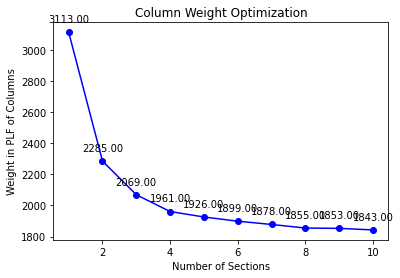

In [16]:
import matplotlib.pyplot as plt
fig = plt.figure()
xs, ys = zip(*plot_pts)

plt.plot(xs,ys,'bo-')

for x,y in zip(xs,ys):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.xlabel('Number of Sections')
plt.ylabel('Weight in PLF of Columns')
plt.title('Column Weight Optimization')
plt.show()